In [498]:
%matplotlib inline

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import itertools
import operator
from commons import *
import logging

import torch
from torch.distributions import constraints, transforms
from torch.autograd import Variable

import pyro
import pyro.distributions as dist
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro import poutine
from pyro.contrib.autoguide import AutoDelta

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

In [882]:
# load data
cluster_cell_counts_array = np.load('/Users/mehrtash/Data/PCL/Human_4C/per_cluster_n_cells.npy')
cluster_gene_expression_array = np.load('/Users/mehrtash/Data/PCL/Human_4C/per_cluster_summed_gene_expression.npy')
cluster_gene_expression_array = cluster_gene_expression_array

n_clusters = cluster_cell_counts_array.size
n_cells_per_cluster = torch.tensor(cluster_cell_counts_array).float()
chi_obs = torch.tensor(cluster_gene_expression_array).float()
nu_vec = torch.tensor(cluster_cell_counts_array).float()
nu_vec = nu_vec / torch.sum(nu_vec)


# mask out unexpressed genes
chi_obs = chi_obs[:, torch.sum(chi_obs, 0) > 0]

# masked out highly expressed genes (5 percentile)
ignore_percentile = 0.001
sorted_gene_indices = list(map(operator.itemgetter(0),
         sorted(enumerate(torch.sum(chi_obs, 0).numpy().tolist()), key=operator.itemgetter(1), reverse=True)))
kept_genes = sorted_gene_indices[int(ignore_percentile * len(sorted_gene_indices)):]
chi_obs = chi_obs[:, kept_genes]

In [913]:
class SparseUnmixingModel(torch.nn.Module):
    def __init__(self, nu_vec, max_p_offdiag=0.1, max_p_doublet=0.1, sparsity=1.0, obs_error_scale=1.0):
        super(SparseUnmixingModel, self).__init__()
        self.nu_vec = nu_vec
        self.n_clusters = nu_vec.shape[0]
        self.max_p_offdiag = max_p_offdiag
        self.max_p_doublet = max_p_doublet
        self.sparsity = sparsity
        self.obs_error_scale = obs_error_scale

    @staticmethod
    def generate_2_cycles(n):
        perm_list = [torch.eye(n)]
        for i in range(n):
            for j in range(i + 1, n):
                perm = torch.eye(n)
                perm[i, i] = 0
                perm[j, j] = 0
                perm[i, j] = 1
                perm[j, i] = 1
                perm_list.append(perm)
        return perm_list

    @staticmethod
    def get_p_mat_from_unc_vars_new(p_unc_vars, n_clusters, min_p_diag=None):
        n_unc_vars = int(n_clusters * (n_clusters - 1) / 2)
        assert p_unc_vars.size() == torch.Size([n_unc_vars])
        perm_mats = generate_2_cycles(n_clusters)
        trans = transforms.StickBreakingTransform() 
        simplex_vars = trans(p_unc_vars)
        p_mat = torch.sum(
            simplex_vars.view((-1, 1, 1)) * torch.cat([perm.unsqueeze(0) for perm in perm_mats]), dim=0)
        if min_p_diag is not None:
            p_mat = (min_p_diag * torch.eye(n_clusters, dtype=p_unc_vars.dtype)
                     + (1 - min_p_diag) * p_mat)
        return p_mat

    def model(self, chi_obs: torch.Tensor, n_cells_per_cluster: torch.Tensor):
        # cluster-to-cluster transition matrix
        n_unc_vars = int(self.n_clusters * (self.n_clusters - 1) / 2)
        p_unc_init = torch.randn(torch.Size([n_unc_vars]))
        p_unc_vars = pyro.param("p_unc_vars", p_unc_init)
        p_mat = self.get_p_mat_from_unc_vars_new(p_unc_vars, self.n_clusters, 1 - self.max_p_offdiag)        
        self.p_mat = p_mat
        
        # doublet formation probability
        p_doublet_unc_init = torch.randn(torch.Size([1]))
        p_doublet_unc_var = pyro.param("p_doublet_unc_var", p_doublet_unc_init)
        p_doublet = self.max_p_doublet * torch.sigmoid(p_doublet_unc_var)
        self.p_doublet = p_doublet
        
        # cluster mixing matrix
        mixing_mat = ((1. - 0.5 * p_doublet) * p_mat * self.nu_vec.view((-1, 1))
                      + 0.5 * p_doublet * torch.matmul(p_mat, self.nu_vec).view((-1, 1)) * self.nu_vec.view((1, -1)))
        expected_cluster_size = torch.matmul(mixing_mat, torch.ones((self.n_clusters,)))
        mixing_mat = mixing_mat / expected_cluster_size.view((-1, 1))
        self.mixing_mat = mixing_mat
        
        # sample true counts from an exponential distribution
        n_genes = chi_obs.shape[1]
        chi_true = pyro.sample("chi_true",
                               dist.Exponential(rate=self.sparsity).expand([self.n_clusters, n_genes]).to_event(2))
        rate = n_cells_per_cluster.view((-1, 1)) * torch.matmul(mixing_mat, chi_true)
#         pyro.sample("chi_obs", dist.Cauchy(loc=rate, scale=self.obs_error_scale).to_event(2), obs=chi_obs)
        pyro.sample("chi_obs", dist.Poisson(rate=rate).to_event(2), obs=chi_obs)

In [940]:
# instantiate the model
unmixing_model = SparseUnmixingModel(nu_vec, max_p_offdiag=0.5, max_p_doublet=0.5, sparsity=0.01, obs_error_scale=1e-3)

# MAP estimate for chi_true
global_guide = AutoDelta(poutine.block(unmixing_model.model, expose=['chi_true']))

pyro.clear_param_store()
pyro.param('auto_chi_true', 
           (chi_obs / n_cells_per_cluster.view((-1, 1))
            + 0.01 * torch.randn_like(chi_obs)).clamp(1e-3),
           constraint=constraints.positive)

optim = pyro.optim.ClippedAdam({'lr': 0.01, 'clip_norm': 1.0})
svi = SVI(unmixing_model.model, global_guide, optim, loss=TraceEnum_ELBO())

In [941]:
optim = pyro.optim.Adam({'lr': 0.01})
svi = SVI(unmixing_model.model, global_guide, optim, loss=TraceEnum_ELBO())

In [953]:
for i in range(50000):
    print(svi.step(chi_obs, n_cells_per_cluster))

3382298.25
3382220.25
3382140.75
3382066.0
3381984.5
3381907.0
3381831.75
3381753.5
3381676.75
3381601.75
3381523.25
3381446.0
3381369.75
3381290.0
3381218.0
3381139.0
3381063.25
3380988.5
3380909.0
3380834.5
3380758.75
3380681.5
3380606.5
3380531.25
3380456.0
3380381.5
3380304.5
3380228.75
3380155.0
3380080.25
3380006.0
3379931.25
3379856.5
3379780.0
3379706.5
3379631.25
3379558.25
3379486.0
3379410.5
3379335.75
3379261.0
3379187.25
3379114.5
3379042.5
3378967.0
3378894.5
3378821.25
3378750.0
3378675.5
3378605.0
3378532.0
3378459.75
3378386.5
3378312.5
3378242.0
3378168.25
3378098.0
3378027.0
3377957.0
3377882.0
3377811.25
3377740.75
3377669.5
3377599.75
3377530.5
3377457.5
3377388.5
3377317.0
3377245.5
3377178.25
3377110.0
3377039.25
3376970.0
3376901.0
3376831.0
3376762.0
3376691.25
3376624.5
3376555.25
3376484.0
3376419.0
3376348.75
3376281.0
3376213.25
3376145.0
3376075.0
3376011.0
3375942.0
3375873.5
3375807.0
3375739.25
3375673.75
3375607.0
3375537.5
3375472.0
3375406.0
3375341.

3345499.0
3345473.0
3345445.0
3345421.0
3345393.0
3345365.75
3345341.0
3345315.5
3345286.75
3345262.0
3345236.5
3345210.0
3345183.25
3345156.25
3345131.5
3345103.25
3345081.5
3345053.25
3345028.5
3345003.0
3344978.25
3344951.75
3344926.5
3344900.25
3344876.0
3344850.0
3344827.0
3344799.0
3344775.0
3344747.0
3344718.5
3344694.75
3344669.0
3344641.5
3344615.25
3344590.0
3344566.5
3344538.5
3344513.75
3344489.0
3344462.25
3344437.75
3344411.75
3344386.0
3344363.0
3344336.75
3344310.5
3344285.5
3344261.5
3344234.25
3344212.5
3344183.0
3344161.25
3344137.0
3344109.0
3344085.5
3344059.5
3344033.5
3344008.75
3343985.0
3343959.0
3343932.5
3343908.75
3343886.0
3343859.25
3343835.5
3343810.5
3343785.75
3343762.0
3343736.0
3343712.5
3343688.5
3343664.5
3343639.0
3343614.0
3343590.5
3343565.0
3343542.75
3343516.25
3343492.5
3343469.0
3343443.5
3343420.25
3343393.0
3343373.0
3343347.75
3343324.0
3343300.75
3343277.0
3343250.5
3343226.25
3343202.75
3343179.0
3343155.25
3343133.0
3343106.75
3343082.7

3331159.0
3331146.5
3331134.25
3331124.5
3331111.5
3331099.25
3331089.0
3331076.75
3331065.0
3331052.5
3331039.5
3331029.75
3331016.5
3331006.0
3330993.75
3330979.75
3330969.5
3330958.25
3330949.0
3330936.75
3330924.75
3330912.5
3330900.5
3330889.25
3330877.5
3330866.5
3330850.75
3330843.5
3330831.25
3330819.5
3330807.0
3330794.25
3330784.5
3330772.75
3330760.25
3330749.25
3330740.0
3330725.75
3330714.5
3330703.0
3330692.0
3330678.75
3330668.0
3330656.75
3330647.5
3330636.5
3330622.5
3330609.75
3330601.5
3330588.0
3330579.0
3330564.75
3330552.5
3330542.5
3330531.5
3330522.75
3330511.0
3330500.5
3330490.75
3330482.0
3330469.5
3330462.0
3330452.0
3330439.25
3330430.0
3330417.0
3330402.5
3330390.5
3330376.0
3330363.75
3330350.25
3330339.5
3330327.0
3330319.0
3330306.5
3330294.5
3330285.0
3330272.75
3330260.0
3330249.0
3330238.0
3330227.5
3330215.5
3330203.75
3330195.5
3330183.0
3330171.5
3330159.0
3330147.75
3330135.0
3330128.0
3330113.5
3330100.5
3330092.5
3330080.25
3330071.5
3330058.5


3324238.5
3324230.75
3324216.5
3324209.0
3324202.0
3324193.0
3324184.0
3324180.5
3324173.0
3324169.0
3324162.5
3324154.0
3324146.0
3324139.75
3324134.5
3324127.0
3324119.25
3324114.25
3324107.5
3324101.75
3324095.0
3324089.5
3324079.5
3324075.0
3324068.25
3324064.0
3324058.0
3324049.5
3324045.75
3324037.0
3324031.0
3324025.0
3324017.5
3324010.0
3324004.5
3323999.5
3323993.0
3323987.25
3323982.0
3323972.0
3323968.5
3323961.0
3323954.25
3323952.5
3323943.5
3323938.0
3323932.5
3323924.5
3323919.5
3323912.5
3323906.0
3323899.0
3323894.5
3323890.5
3323883.0
3323875.0
3323868.0
3323864.5
3323857.5
3323850.0
3323842.75
3323836.75
3323831.0
3323826.0
3323818.0
3323814.25
3323808.0
3323800.75
3323795.5
3323790.0
3323783.5
3323776.5
3323771.0
3323763.0
3323756.0
3323751.5
3323746.0
3323738.5
3323732.5
3323726.25
3323721.5
3323713.5
3323708.5
3323703.5
3323696.0
3323690.75
3323686.0
3323679.0
3323671.75
3323667.5
3323661.0
3323654.0
3323646.0
3323642.5
3323636.0
3323631.5
3323623.75
3323619.5
332

3320188.25
3320182.25
3320179.0
3320173.0
3320171.0
3320164.75
3320165.5
3320161.0
3320159.0
3320153.0
3320149.0
3320146.5
3320140.75
3320138.25
3320134.75
3320130.75
3320128.5
3320123.25
3320120.5
3320116.25
3320115.75
3320108.0
3320104.0
3320102.75
3320099.0
3320095.0
3320093.75
3320089.25
3320083.75
3320078.5
3320076.5
3320072.5
3320070.5
3320065.0
3320063.0
3320058.5
3320057.5
3320052.0
3320047.5
3320043.75
3320040.5
3320040.0
3320033.75
3320031.0
3320026.0
3320023.0
3320020.5
3320016.0
3320015.0
3320009.25
3320006.25
3320003.0
3319998.5
3319994.75
3319991.0
3319989.75
3319985.5
3319979.5
3319978.75
3319974.5
3319972.5
3319968.25
3319964.25
3319957.75
3319955.5
3319954.0
3319948.0
3319948.0
3319942.5
3319938.25
3319937.5
3319933.0
3319930.0
3319929.0
3319924.0
3319918.75
3319915.75
3319912.0
3319909.0
3319905.0
3319903.25
3319898.5
3319895.5
3319890.75
3319888.5
3319887.25
3319882.5
3319880.5
3319874.0
3319875.25
3319869.0
3319866.75
3319862.0
3319860.75
3319855.5
3319854.5
3319848

3318046.25
3318044.0
3318041.75
3318041.5
3318037.5
3318034.5
3318034.0
3318031.0
3318030.5
3318026.75
3318025.75
3318024.0
3318020.0
3318018.75
3318018.5
3318013.75
3318012.0
3318012.0
3318009.0
3318009.0
3318006.0
3318003.5
3318001.75
3318000.25
3317999.25
3317997.0
3317994.0
3317989.0
3317989.0
3317987.5
3317983.25
3317983.25
3317979.0
3317979.0
3317976.5
3317978.0
3317973.25
3317970.75
3317969.5
3317968.5
3317965.25
3317963.0
3317961.75
3317958.25
3317956.5
3317954.0
3317953.25
3317952.5
3317948.25
3317947.5
3317944.75
3317944.25
3317941.5
3317938.0
3317938.0
3317936.0
3317933.25
3317933.25
3317928.5
3317930.0
3317925.5
3317923.5
3317922.5
3317920.75
3317917.5
3317917.75
3317915.25
3317912.0
3317910.5
3317907.0
3317904.5
3317906.5
3317900.0
3317901.75
3317900.0
3317897.5
3317897.0
3317894.0
3317892.0
3317889.5
3317889.0
3317885.75
3317882.0
3317882.25
3317878.0
3317878.0
3317875.5
3317873.0
3317873.5
3317870.5
3317868.5
3317867.5
3317864.0
3317860.5
3317860.0
3317860.25
3317858.5
3

KeyboardInterrupt: 

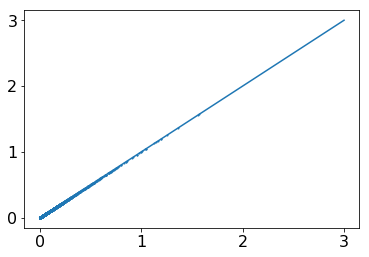

In [958]:
i_cluster = 0
sparse_chi = np.log(1. + global_guide(chi_obs)['chi_true'][i_cluster, :].detach().numpy())
orig_chi = np.log(1. + chi_obs[i_cluster, :] / n_cells_per_cluster[i_cluster])
plt.scatter(orig_chi, sparse_chi, s=1)
plt.plot([0, 3], [0, 3])

In [959]:
unmixing_model.p_doublet

tensor([0.0011], grad_fn=<MulBackward0>)

In [960]:
unmixing_model.mixing_mat

tensor([[9.9858e-01, 6.6244e-05, 7.4399e-05, 5.8367e-05, 4.8170e-04, 7.0733e-05,
         3.2981e-04, 6.9224e-05, 2.0614e-05, 1.8215e-05, 1.7008e-04, 1.4007e-05,
         9.8599e-06, 2.7973e-05, 6.3727e-06, 2.1081e-06],
        [1.5371e-04, 9.9946e-01, 6.3974e-05, 5.9004e-05, 5.8852e-05, 4.3399e-05,
         4.3457e-05, 4.3972e-05, 2.1548e-05, 1.5884e-05, 1.0084e-05, 8.7214e-06,
         4.2530e-06, 3.6792e-06, 5.9096e-06, 2.0079e-06],
        [1.6584e-04, 6.7952e-05, 9.9933e-01, 5.6082e-05, 1.7024e-04, 4.5118e-05,
         4.1698e-05, 4.7505e-05, 1.6742e-05, 1.5836e-05, 1.2753e-05, 1.1493e-05,
         4.0610e-06, 6.4113e-06, 3.0513e-06, 2.1368e-06],
        [1.5565e-04, 6.8828e-05, 6.1927e-05, 9.9947e-01, 5.5504e-05, 4.3393e-05,
         4.1574e-05, 3.4795e-05, 1.6535e-05, 1.9053e-05, 1.0015e-05, 7.6493e-06,
         4.0864e-06, 3.2677e-06, 2.6348e-06, 1.9639e-06],
        [5.7933e-04, 6.8963e-05, 1.7637e-04, 5.5784e-05, 9.9891e-01, 4.4217e-05,
         4.8311e-05, 4.1768e-05, 1.6510

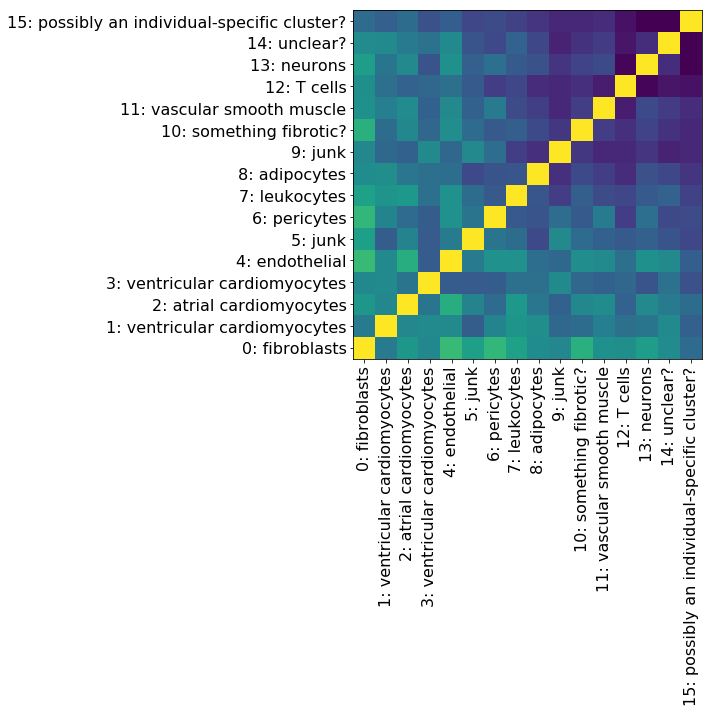

In [957]:
cluster_labels = {
    0: 'fibroblasts',
    1: 'ventricular cardiomyocytes',
    2: 'atrial cardiomyocytes',
    3: 'ventricular cardiomyocytes',
    4: 'endothelial',
    5: 'junk',
    6: 'pericytes',
    7: 'leukocytes',
    8: 'adipocytes',
    9: 'junk',
    10: 'something fibrotic?',
    11: 'vascular smooth muscle',
    12: 'T cells',
    13: 'neurons',
    14: 'unclear?',
    15: 'possibly an individual-specific cluster?'}

fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.imshow(np.log(unmixing_model.p_mat.detach().numpy()), origin='lower')
tick_labels = [str(j) + ": " + cluster_labels[j] for j in range(n_clusters)]
ax.set_xticks([j for j in range(n_clusters)])
ax.set_xticklabels(tick_labels, rotation=90)
ax.set_yticks([j for j in range(n_clusters)])
ax.set_yticklabels(tick_labels)
plt.tight_layout()
# plt.savefig('/Users/mehrtash/Data/PCL/Human_4C/unmixing_run_2.pdf')